In [39]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

from autoencoders.autoencoder import Autoencoder
from utils.stacked_mnist import StackedMNISTData, DataMode
from utils.verification_net import VerificationNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Standard Autoencoder

## Mono MNIST

### Data

In [ ]:
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)
x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

### Train

In [41]:
# Train autoencoder
encoding_dim = 8 
autoencoder = Autoencoder(encoding_dim)
autoencoder.summary()
autoencoder.train(x_train, epochs=20, batch_size=256, force_relearn=True)

(60000, 28, 28, 1)
Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 4, 32)          2080      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64) 

True

In [42]:
# Train verification network
net = VerificationNet(force_learn=False)
net.train(generator=gen, epochs=10)

D:\Anaconda\envs\ML3.9\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


True

### Assess model

In [43]:
# Check coverage, predictability, and accuracy
x_pred = autoencoder(x_test)
cov = net.check_class_coverage(data=x_pred, tolerance=.8)
pred, acc = net.check_predictability(data=x_pred, correct_labels=y_test)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

(10000, 8, 1)
(10000, 28, 28)
(10000, 28, 28, 1)
Coverage: 100.00%
Predictability: 86.93%
Accuracy: 81.20%


### Reconstruction

(10, 8, 1)
(10, 8, 1)
(10, 28, 28)


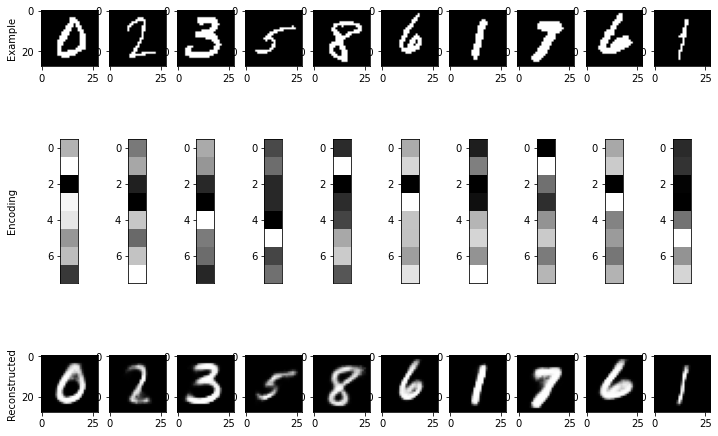

In [44]:
# Visualize reconstructions
n_examples = 10

idx = np.random.choice(x_test.shape[0], n_examples, replace=False)
examples = x_test[idx]
encoded = autoencoder.encode(examples)
reconstructed = autoencoder(examples)

fig, ax = plt.subplots(3, n_examples, figsize=(12, 9))
for n in range(n_examples):
    ax[0][n].imshow(examples[n], cmap='gray')
    ax[1][n].imshow(encoded[n].reshape((encoding_dim, 1)), cmap='gray')
    ax[1][n].set_xticks([])
    ax[2][n].imshow(reconstructed[n], cmap='gray')
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Reconstructed')
fig.align_ylabels()
plt.show()

### Generation

(10, 28, 28)


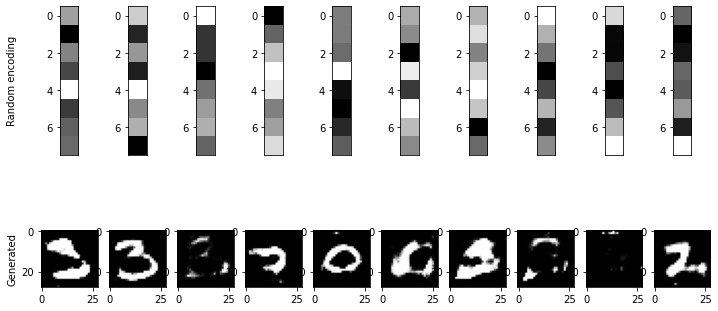

In [45]:
# Visualize generation
n_examples = 10

z = np.random.randn(n_examples, encoding_dim, 1)
generated = autoencoder.decode(z)

fig, ax = plt.subplots(2, n_examples, figsize=(12, 6))
for n in range(n_examples):
    ax[0][n].imshow(z[n].reshape((encoding_dim, 1)), cmap='gray')
    ax[0][n].set_xticks([])
    ax[1][n].imshow(generated[n], cmap='gray')
ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Generated')
fig.align_ylabels()
plt.show()

### Anomaly Detection

In [46]:
missing_gen = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING)

# Train autoencoder
x_train_missing, y_train_missing = missing_gen.get_full_data_set(training=True)

missing_autoencoder = Autoencoder(encoding_dim, file_name="./models/missing_autoencoder/autoencoder")
missing_autoencoder.summary()
missing_autoencoder.train(x_train_missing, epochs=20, batch_size=256, force_relearn=True)


Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 4, 4, 32)          2080      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256

True

In [47]:
# Calculating reconstruction losses with test set with no missing digits
loss = missing_autoencoder.reconstruction_loss(x_test)

10000/10000 [==============================] - 20s 2ms/step - loss: 0.1119


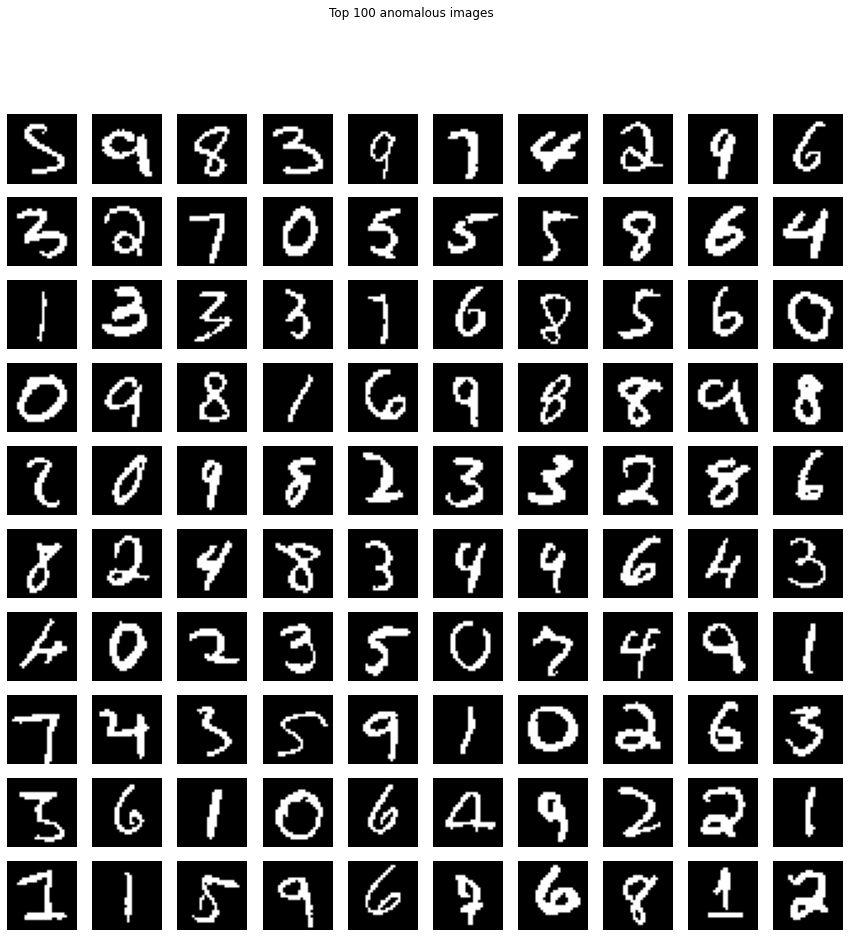

In [48]:
grid_size = 10
# Get n largest loss indexes
idx = (-loss).argsort()[:grid_size**2]
fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
for n in range(grid_size):
    for m in range(grid_size): 
        ax[n][m].imshow(x_test[idx[grid_size*n + m]], cmap='gray')
        ax[n][m].axis('off')
fig.suptitle(f'Top {grid_size**2} anomalous images')
plt.show()

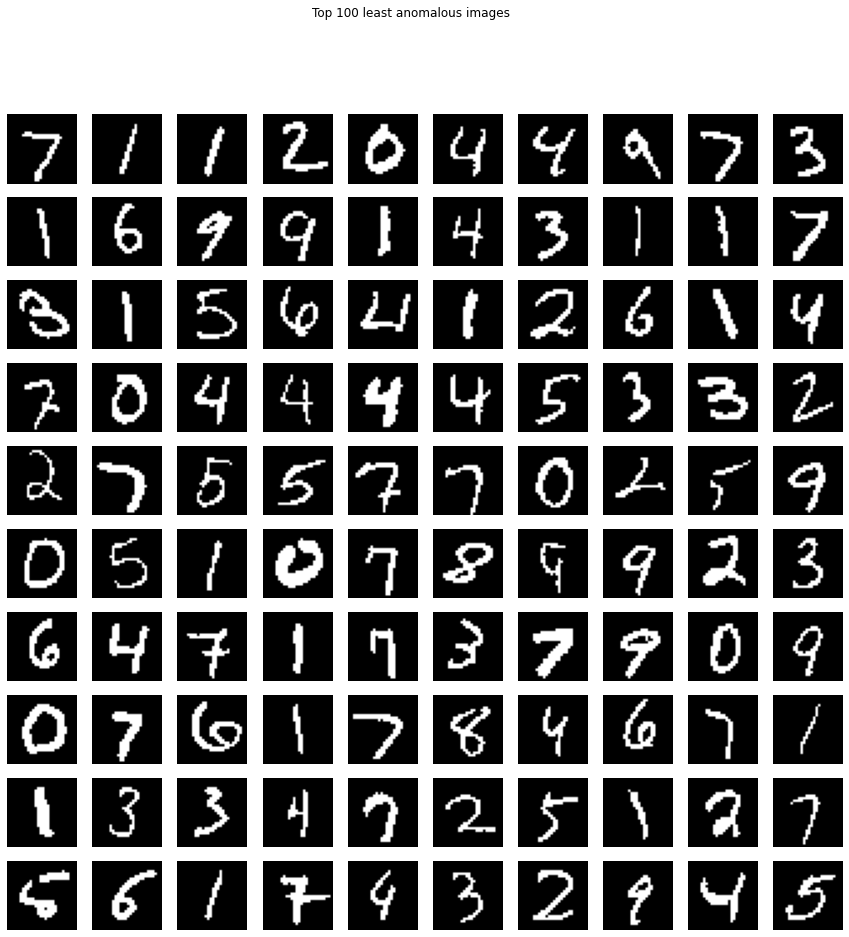

In [49]:
grid_size = 10
# Get n largest loss indexes
idx = loss.argsort()[:grid_size**2]
fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
for n in range(grid_size):
    for m in range(grid_size): 
        ax[n][m].imshow(x_test[idx[grid_size*n + m]], cmap='gray')
        ax[n][m].axis('off')
fig.suptitle(f'Top {grid_size**2} least anomalous images')
plt.show()

## Color MNIST

### Data

In [ ]:
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)
x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

### Train

In [67]:
encoding_dim = 8 
color_autoencoder = Autoencoder(encoding_dim, file_name='./models/color_autoencoder/autoencoder')
color_autoencoder.summary()
color_autoencoder.train(x_train, epochs=20, batch_size=256, force_relearn=True)

Could not read weights for autoencoder from file. Must retrain...
Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 4, 4, 32)          2080      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 128)               0         
                                                           

True

### Assess model

In [81]:
# Check coverage, predictability, and accuracy
x_pred = color_autoencoder(x_test)
cov = net.check_class_coverage(data=x_pred, tolerance=.5)
pred, acc = net.check_predictability(data=x_pred, correct_labels=y_test, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 87.20%
Accuracy: 70.96%


### Reconstruction

(10, 28, 28, 3)


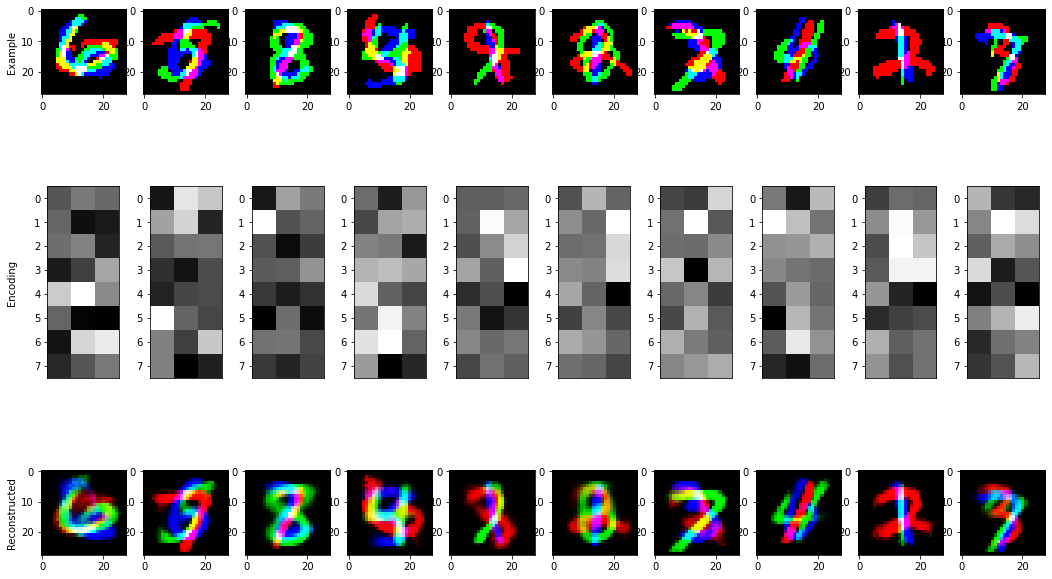

In [77]:
# Visualize reconstructions
n_examples = 10

idx = np.random.choice(x_test.shape[0], n_examples, replace=False)
examples = x_test[idx]
print(examples.shape)
encoded = color_autoencoder.encode(examples)
reconstructed = color_autoencoder(examples)

fig, ax = plt.subplots(3, n_examples, figsize=(18, 12))
for n in range(n_examples):
    ax[0][n].imshow(examples[n]*255)
    ax[1][n].imshow(encoded[n].reshape((encoding_dim, 3)), cmap='gray')
    ax[1][n].set_xticks([])
    ax[2][n].imshow(reconstructed[n])
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Reconstructed')
fig.align_ylabels()
plt.show()

## Generation

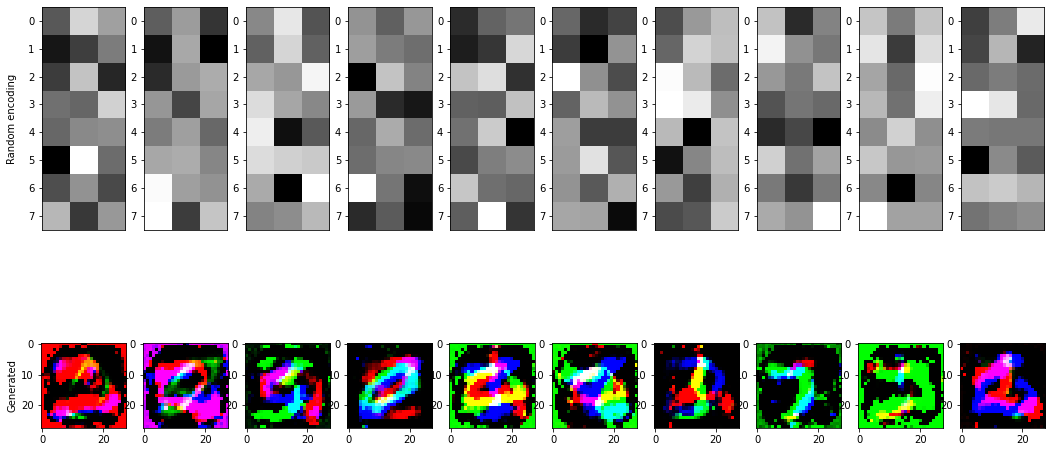

In [80]:
# Visualize generation
n_examples = 10

z = np.random.randn(n_examples, encoding_dim, 3)
generated = color_autoencoder.decode(z)

fig, ax = plt.subplots(2, n_examples, figsize=(18, 9))
for n in range(n_examples):
    ax[0][n].imshow(z[n], cmap='gray')
    ax[0][n].set_xticks([])
    ax[1][n].imshow(generated[n])
ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Generated')
fig.align_ylabels()
plt.show()